In [5]:
import os
import io
import re
import tqdm

import numpy as np
import webdataset as wds
import tensorflow as tf
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Any

In [2]:
def decode_xyz(key: str, data: Any) -> Tuple[np.ndarray, np.ndarray] | Tuple[None, None]:
    """
    Webdataset pipeline function for decoding xyz files.

    Arguments:
        key: Stream value key. If the key is ``'.xyz'``, then the data is decoded.
        data: Data to decode.

    Returns:
        Tuple (**xyz**, **scan_window**), where

        - **xyz** - Decoded atom coordinates and elements as an array where each row is of the form ``[x, y, z, element]``.
        - **scan_window** - The xyz coordinates of the opposite corners of the scan window in the form
          ``((x_start, y_start, z_start), (x_end, y_end, z_end))``

        If the stream key did not match, the tuple is ``(None, None)`` instead.
    """
    if key == ".xyz":
        data = io.BytesIO(data)
        atom_number = data.readline().decode("utf-8")
        comment = data.readline().decode("utf-8")
        sw = get_scan_window_from_comment(comment)
        xyz = []
        while line := data.readline().decode("utf-8"):
            e, x, y, z = line.strip().split()[:4]
            e = int(e)
            xyz.append([np.float32(x), np.float32(y), np.float32(z), e])
        return np.array(xyz).astype(np.float32), sw
    else:
        return None, None

def get_scan_window_from_comment(comment: str) -> np.ndarray:
    """
    Process the comment line in a .xyz file and extract the bounding box of the scan.
    The comment either has the format (QUAM dataset)

        ``Lattice="x0 x1 x2 y0 y1 y2 z0 z1 z2"``

    where the lattice is assumed to be orthogonal and origin at zero, or

        ``Scan window: [[x_start y_start z_start], [x_end y_end z_end]]``

    Arguments:
        comment: Comment to parse.

    Returns:
        The xyz coordinates of the opposite corners of the scan window in the form
            ``((x_start, y_start, z_start), (x_end, y_end, z_end))``
    """
    comment = comment.lower()
    match = re.match('.*lattice="((?:[+-]?(?:[0-9]*\.)?[0-9]+\s?){9})"', comment)
    if match:
        vectors = np.array([float(s) for s in match.group(1).split()])
        vectors = vectors.reshape((3, 3))
        sw = np.zeros((2, 3), dtype=np.float32)
        sw[1] = np.diag(vectors)
    elif match := re.match(
        r".*scan window: [\[(]{2}\s*((?:[+-]?(?:[0-9]*\.)?[0-9]+(?:e[-+]?[0-9]+)?,?\s*){3})[\])],\s*[\[(]\s*((?:[+-]?(?:[0-9]*\.)?[0-9]+(?:e[-+]?[0-9]+)?,?\s*){3})[\])]{2}.*",
        comment,
    ):
        start = np.array([float(s.strip(',')) for s in match.group(1).split()])
        end = np.array([float(s.strip(',')) for s in match.group(2).split()])
        sw = np.stack([start, end], axis=0)
    else:
        raise ValueError(f"Could not parse scan window in comment: `{comment}`")
    return sw

def batch_to_numpy(batch: Dict[str, Any]):
    images = []
    for k, v in batch.items():
        # If key ends in png, it is an image
        if k.endswith(".png"):
            images.append(v)
        # If key ends in .xyz, it is tuple (xyz, scan_window)
    xyz, sw = batch['xyz']

    # Keep only water hydrogen and oxygen atoms
    xyz = xyz[xyz[:, 3] < 9]

    # Add column to xyz for charge (index 3) value 0
    charge = np.zeros((xyz.shape[0], 1), dtype=np.float32)
    xyz = np.concatenate([xyz[:, :-1], charge, xyz[:, [-1]]], axis=1)

    x = np.stack(images, axis=0)
    return x, xyz, sw

In [3]:
# Read urls
directory = "/l/data/molnet/Water-bilayer"
urls = [
    os.path.join(directory, f)
    for f in os.listdir(directory)
]

# Create dataset
dataset = wds.WebDataset(urls).decode("l", decode_xyz)
dl = iter(dataset)

/u/79/kurkil1/unix/.venvs/tf-2.13/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [4]:
for i, batch in enumerate(dl):
    x, xyz, sw = batch_to_numpy(batch)

    print(f"x.shape: {x.shape}")
    print(f"xyz.shape: {xyz.shape}")

    print(f"xyz: {xyz}")
    print(f"sw: {sw}")

    print(f"xmean, xstd: {x.mean()}, {x.std()}")

    break


x.shape: (15, 256, 256)
xyz.shape: (423, 5)
xyz: [[26.398178 22.388605  8.42961   0.        1.      ]
 [25.607962 23.294563  9.460139  0.        1.      ]
 [22.288376  9.068551 11.096041  0.        1.      ]
 ...
 [42.01877  27.641527  8.17071   0.        8.      ]
 [44.735985 27.60759   7.8612    0.        8.      ]
 [46.215298 25.100815  8.18034   0.        8.      ]]
sw: [[12.73538425 -1.74714351 18.55545434]
 [44.61038425 30.12785649 21.85545434]]
xmean, xstd: 0.5882532596588135, 0.3119565546512604


In [210]:
item = next(dl)
x, xyz, sw = batch_to_numpy(item)

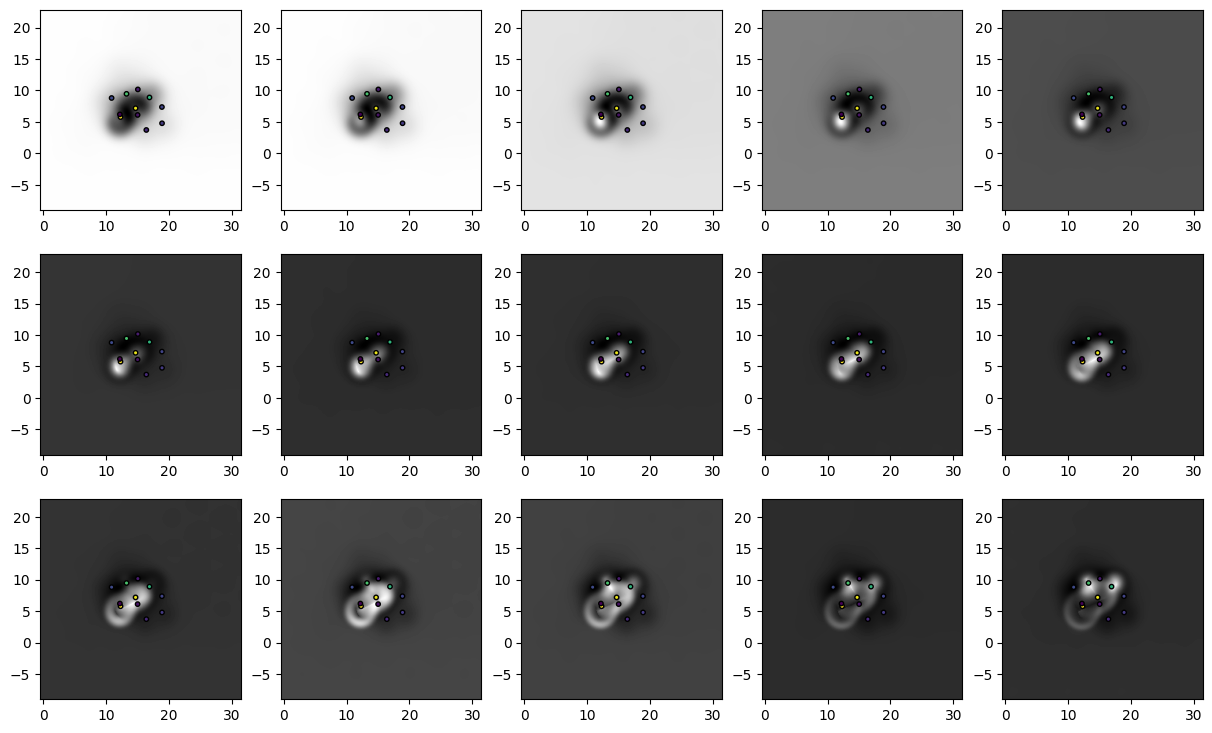

In [211]:
fig = plt.figure(figsize=(15, 9))
for i in range(x.shape[0]):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(x[i], cmap="gray", origin="upper", extent=[sw[0, 0], sw[1, 0], sw[0, 1], sw[1, 1]])

    # Plot atoms
    xyz1 = xyz[xyz[:, 4] == 8]
    xyz1 = xyz1[xyz1[:, 2] > xyz1[:, 2].max() - 3]
    ax.scatter(xyz1[:, 0], xyz1[:, 1], c=xyz1[:, 2], cmap="viridis", s=10, edgecolors="k")


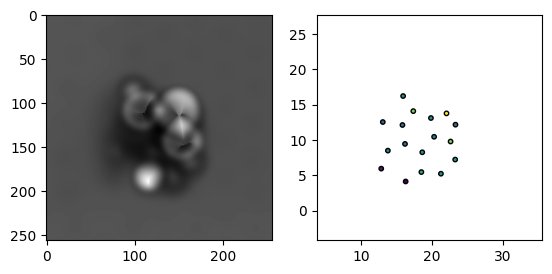

In [182]:
item = next(dl)
x, xyz, sw = batch_to_numpy(item)

ax = plt.subplot(121)
image = x.transpose(0, 2, 1)
ax.imshow(x[-1], cmap="gray", origin="upper")

ax = plt.subplot(122)
xyz1 = xyz[xyz[:, 4] == 8]
xyz1 = xyz1[xyz1[:, 2] > xyz1[:, 2].max() - 3]
ax.scatter(xyz1[:, 0], xyz1[:, 1], c=xyz1[:, 2], cmap="viridis", s=10, edgecolors="k")
ax.set_xlim(sw[0,0], sw[1,0])
ax.set_ylim(sw[0,1], sw[1,1])
ax.set_aspect("equal")


### Iterate over the dataset and save in TF format

In [232]:
# Create dataset
dataset = wds.WebDataset(urls).decode("l", decode_xyz)
dl = iter(dataset)

# First save the images to individual temporary files for later use
gen = generator(dl)
outputdir = "/l/data/molnet/Water-bilayer-temp"
os.makedirs(outputdir, exist_ok=True)

for i, batch in tqdm.tqdm(enumerate(gen)):
    np.savez(
        os.path.join(outputdir, f"batch_{i}"),
        **batch
    )

/u/79/kurkil1/unix/.venvs/tf-2.13/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")
11980it [02:43, 73.19it/s]


In [275]:
def save_afms(
    files: List[str],
    save_dir: str,
):
    signature = {
        "x": tf.TensorSpec(shape=(256, 256, 15), dtype=tf.float32),
        "xyz": tf.TensorSpec(shape=(None, 5), dtype=tf.float32),
        "sw": tf.TensorSpec(shape=(2, 3), dtype=tf.float32),
    }

    def generator():
        for f in files:
            sample = np.load(f)
            # x shape [Z, X, Y] -> [Y, X, Z]
            #print(f"x.shape: {x.shape}")

            yield {
                "x": sample["x"],#.transpose(2, 0, 1),
                "xyz": sample["xyz"],
                "sw": sample["sw"],
            }

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=signature
    )

    os.makedirs(save_dir, exist_ok=True)
    ds.save(save_dir)

In [280]:
files = [
    os.path.join(outputdir, f)
    for f in os.listdir(outputdir)
    if f.endswith(".npz")
]

files = sorted(files, key=lambda x: int(x.split("_")[-1].split(".")[0]))

In [281]:
chunk_size = 1024

# Repeat files so that len(files) is a multiple of chunk_size
n = len(files)
n_chunks = n // chunk_size
n_files = n_chunks * chunk_size
files = files * (n_chunks + 1)
files = files[:n_files]

print(f"Saving {len(files)} files in chunks of {chunk_size}")

Saving 11264 files in chunks of 1024


In [283]:
# Divide files into chunks of size chunk_size
chunks = [
    files[i:i + chunk_size]
    for i in range(0, len(files), chunk_size)
]

print(f"Saving {len(chunks)} chunks")
print(f"First chunk: {chunks[0]}")

Saving 11 chunks
First chunk: ['/l/data/molnet/Water-bilayer-temp/batch_0.npz', '/l/data/molnet/Water-bilayer-temp/batch_1.npz', '/l/data/molnet/Water-bilayer-temp/batch_2.npz', '/l/data/molnet/Water-bilayer-temp/batch_3.npz', '/l/data/molnet/Water-bilayer-temp/batch_4.npz', '/l/data/molnet/Water-bilayer-temp/batch_5.npz', '/l/data/molnet/Water-bilayer-temp/batch_6.npz', '/l/data/molnet/Water-bilayer-temp/batch_7.npz', '/l/data/molnet/Water-bilayer-temp/batch_8.npz', '/l/data/molnet/Water-bilayer-temp/batch_9.npz', '/l/data/molnet/Water-bilayer-temp/batch_10.npz', '/l/data/molnet/Water-bilayer-temp/batch_11.npz', '/l/data/molnet/Water-bilayer-temp/batch_12.npz', '/l/data/molnet/Water-bilayer-temp/batch_13.npz', '/l/data/molnet/Water-bilayer-temp/batch_14.npz', '/l/data/molnet/Water-bilayer-temp/batch_15.npz', '/l/data/molnet/Water-bilayer-temp/batch_16.npz', '/l/data/molnet/Water-bilayer-temp/batch_17.npz', '/l/data/molnet/Water-bilayer-temp/batch_18.npz', '/l/data/molnet/Water-bilayer

In [284]:
# Save chunks
save_dir = "/l/data/molnet/water-bilayer-tf"
for chunk in tqdm.tqdm(chunks):
    first_index = chunk[0].split("_")[-1].split(".")[0]
    last_index = chunk[-1].split("_")[-1].split(".")[0]
    save_name = f"afms_{first_index}_{last_index}"
    save_afms(
        chunk,
        os.path.join(save_dir, save_name)
    )

100%|██████████| 11/11 [01:59<00:00, 10.87s/it]
